In [1]:
# Necessary Imports
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import dask.dataframe as dd
from pathlib import Path
import re

/home/kwilliams/dev/stolen-probability-ptl/venv-torch-1.12.1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Recalculate Attention Statistics CSV

In [169]:
'''
When calculating the angles, I thought I could just calculate those statistics and merge with my attn_stats.csv. But there are mismatching row counts!
The angles DataFrame had more rows, which makes me think I accidentally deleted some positions of data when merging my originally collected statistics
with the token data for each question. So, I'm going to re-make the CSVs. 
'''
head_dfs = []
base = Path('./experiments/embed_dim_512/8_heads/base/finetune/attn_stats')

for layer_dir in base.glob('./*'):
    layer_num, *extras = re.findall(r'\d+', layer_dir.name)
    assert not extras
    layer_num = int(layer_num)

    for head_path in layer_dir.glob('*.csv'):
        head_num, *extras = re.findall(r'\d+', head_path.name)
        assert not extras
        head_num = int(head_num)

        head = pd.read_csv(head_path)
        head = head.drop(columns=['question_len']) # this messes up the rsplit below

        head = pd.melt(head, id_vars=['step'], var_name='variable', value_name='value')
        head[['feature', 'pos']] = head['variable'].str.rsplit('_', n=1, expand=True)
        head = head.pivot_table(index=['step', 'pos'], columns='feature', values='value', aggfunc='first').reset_index()
        head = head.dropna()
        head.columns.name = None
        head['layer'] = layer_num
        head['head'] = head_num

        head_dfs.append(head)

stats = pd.concat(head_dfs, ignore_index=True)
stats.to_csv(base.parent / 'attn_stats_2.csv', index=False)

# 64-head Plots

In [66]:
'''
Hyperparameters for Visualizations
'''
HEADS = 64
LAYERS = 4
PLOTS_PER_ROW = 8
assert HEADS % PLOTS_PER_ROW == 0
FIGSIZE = (25, 25)

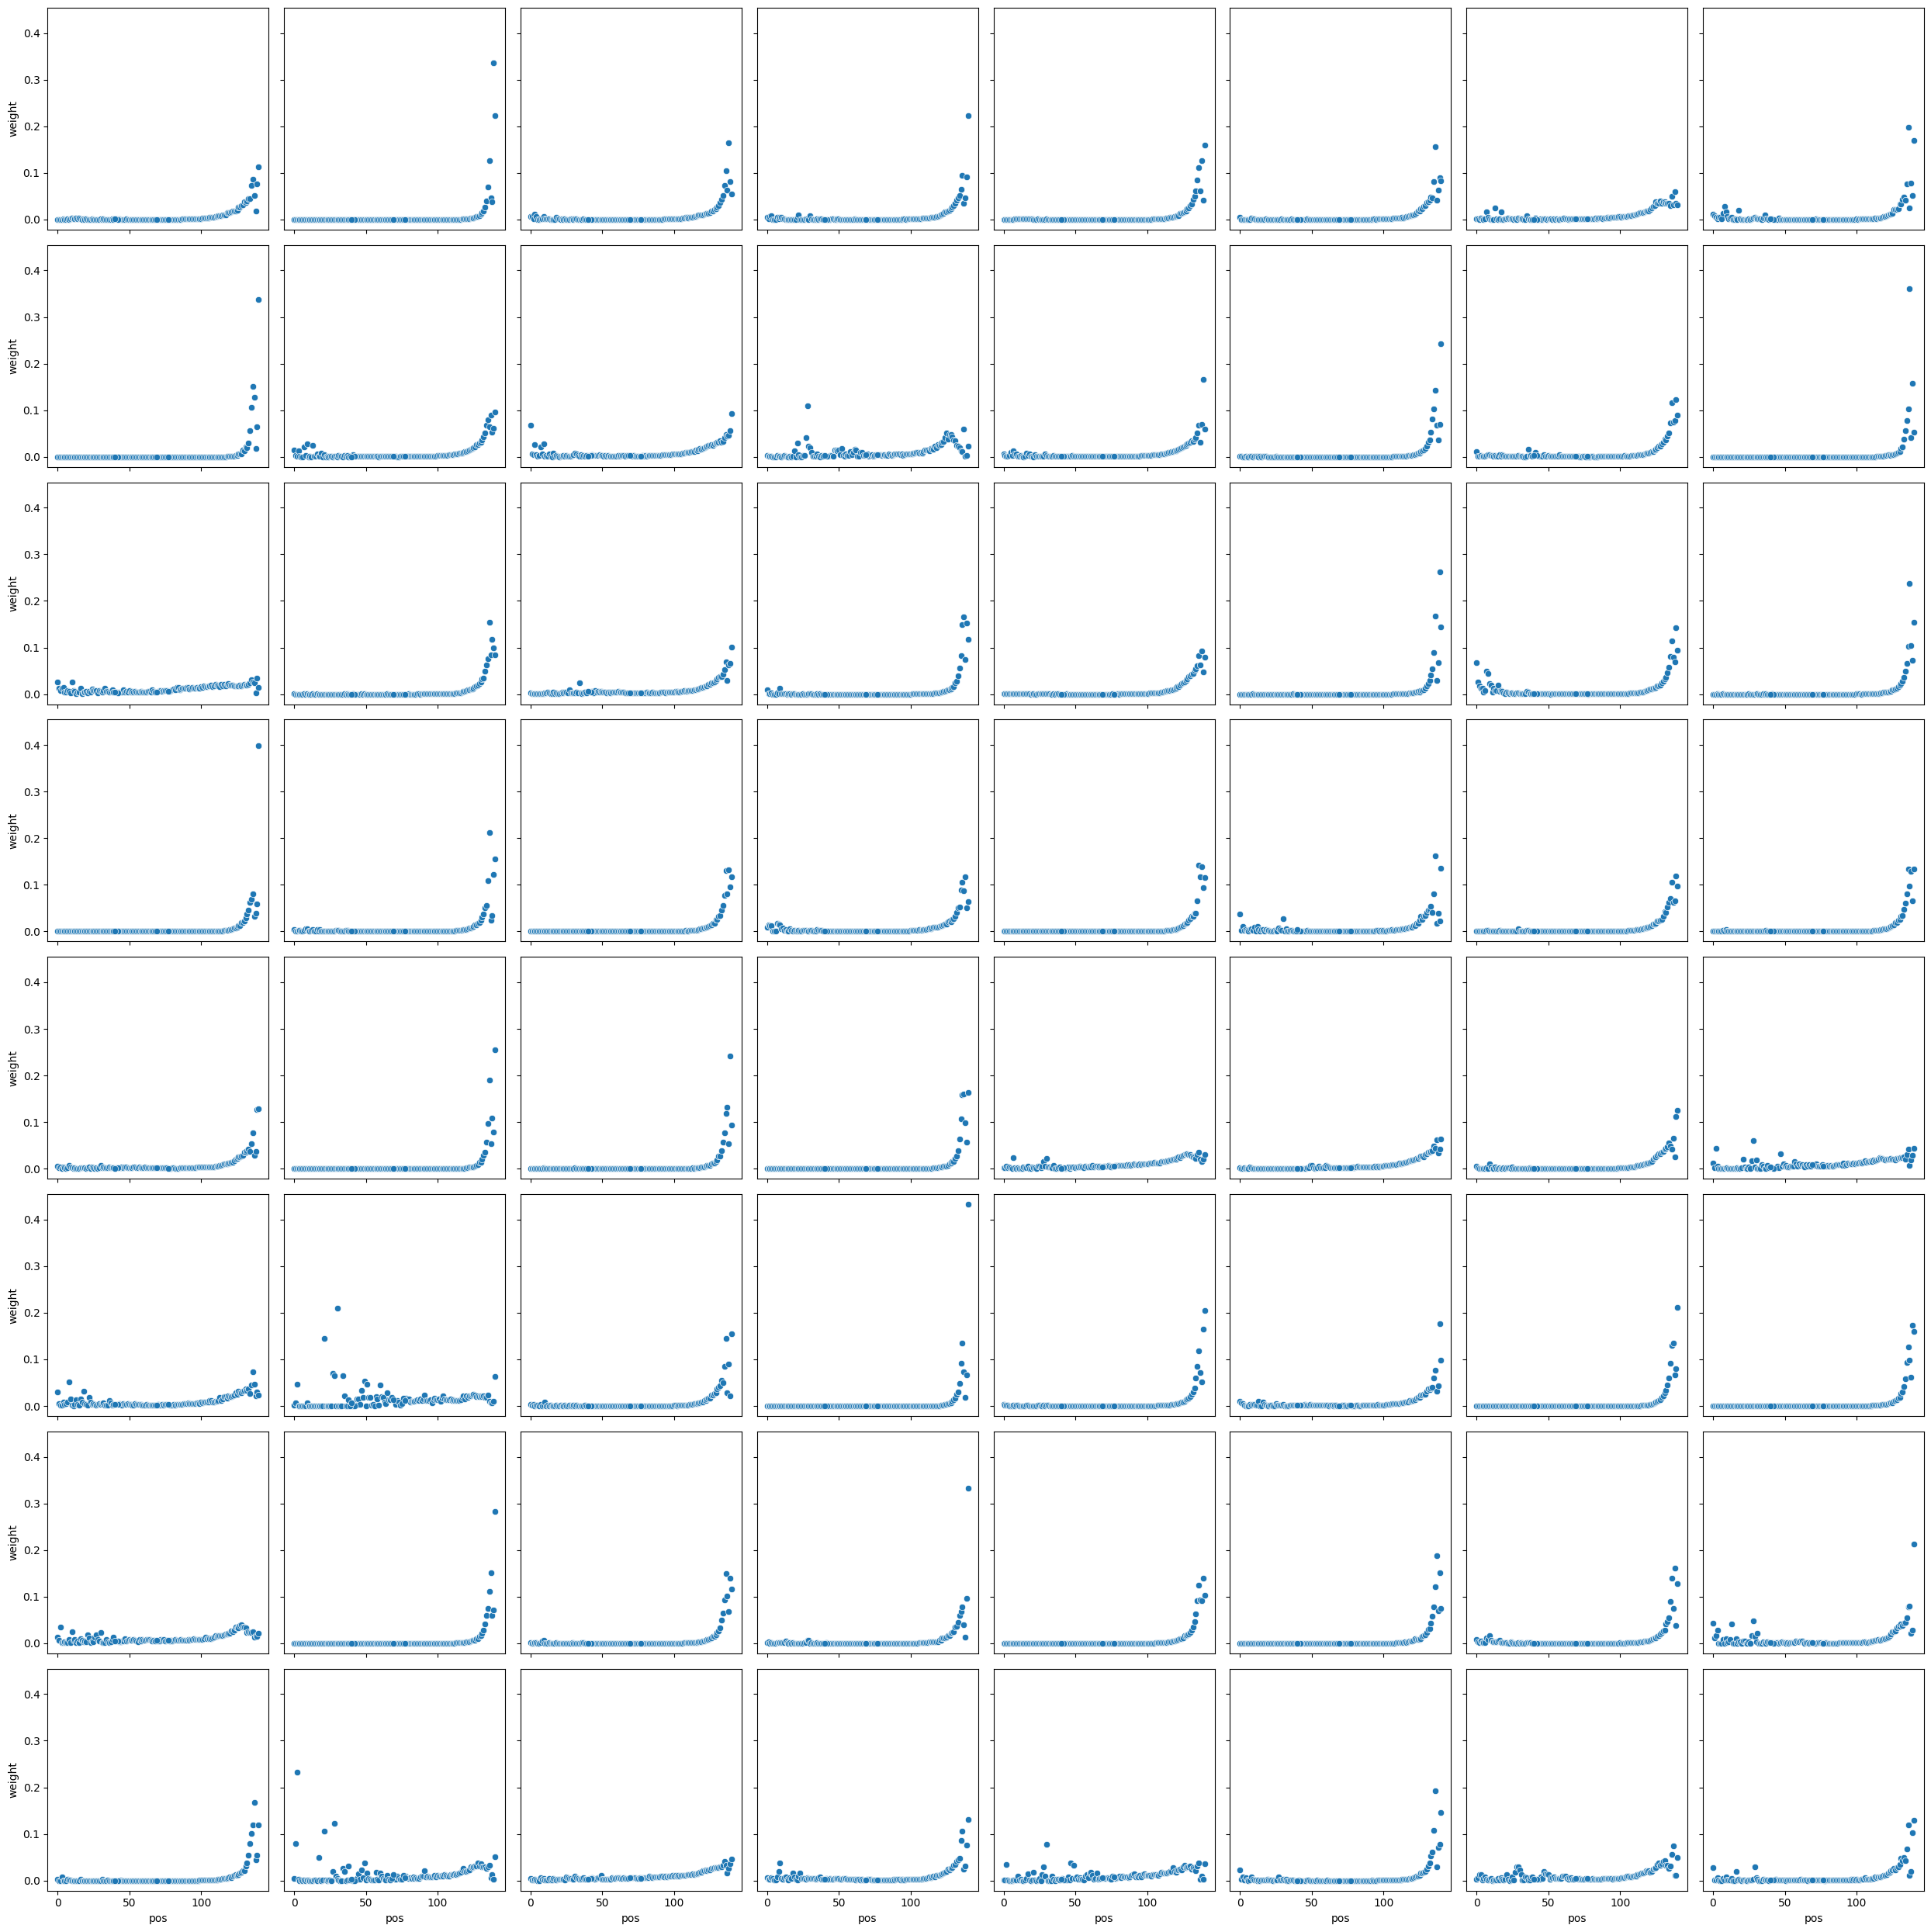

In [10]:
'''
How do heads spread attention throughout the sequence length? What is the average attention weight assigned to each position?
'''
stats = dd.read_csv('./experiments/embed_dim_512/64_heads/base/finetune/attn_stats.csv')
stats = stats.groupby(['layer', 'head', 'pos']).agg({'weight': 'mean'}).reset_index().compute()

def filter(df, layer, head):
    ret = df[df['layer']==layer]
    ret = ret[ret['head']==head]
    return ret

fig, ax = plt.subplots(HEADS // PLOTS_PER_ROW, PLOTS_PER_ROW, figsize=FIGSIZE, sharex=True, sharey=True)

LAYER = 8
for l in range(LAYER, LAYER + 1):
    for h in range(HEADS):
        r, c = divmod(h, PLOTS_PER_ROW)
        subset = filter(stats, l, h)
        sns.scatterplot(subset, x='pos', y='weight', ax=ax[r, c])
plt.tight_layout()
plt.show()

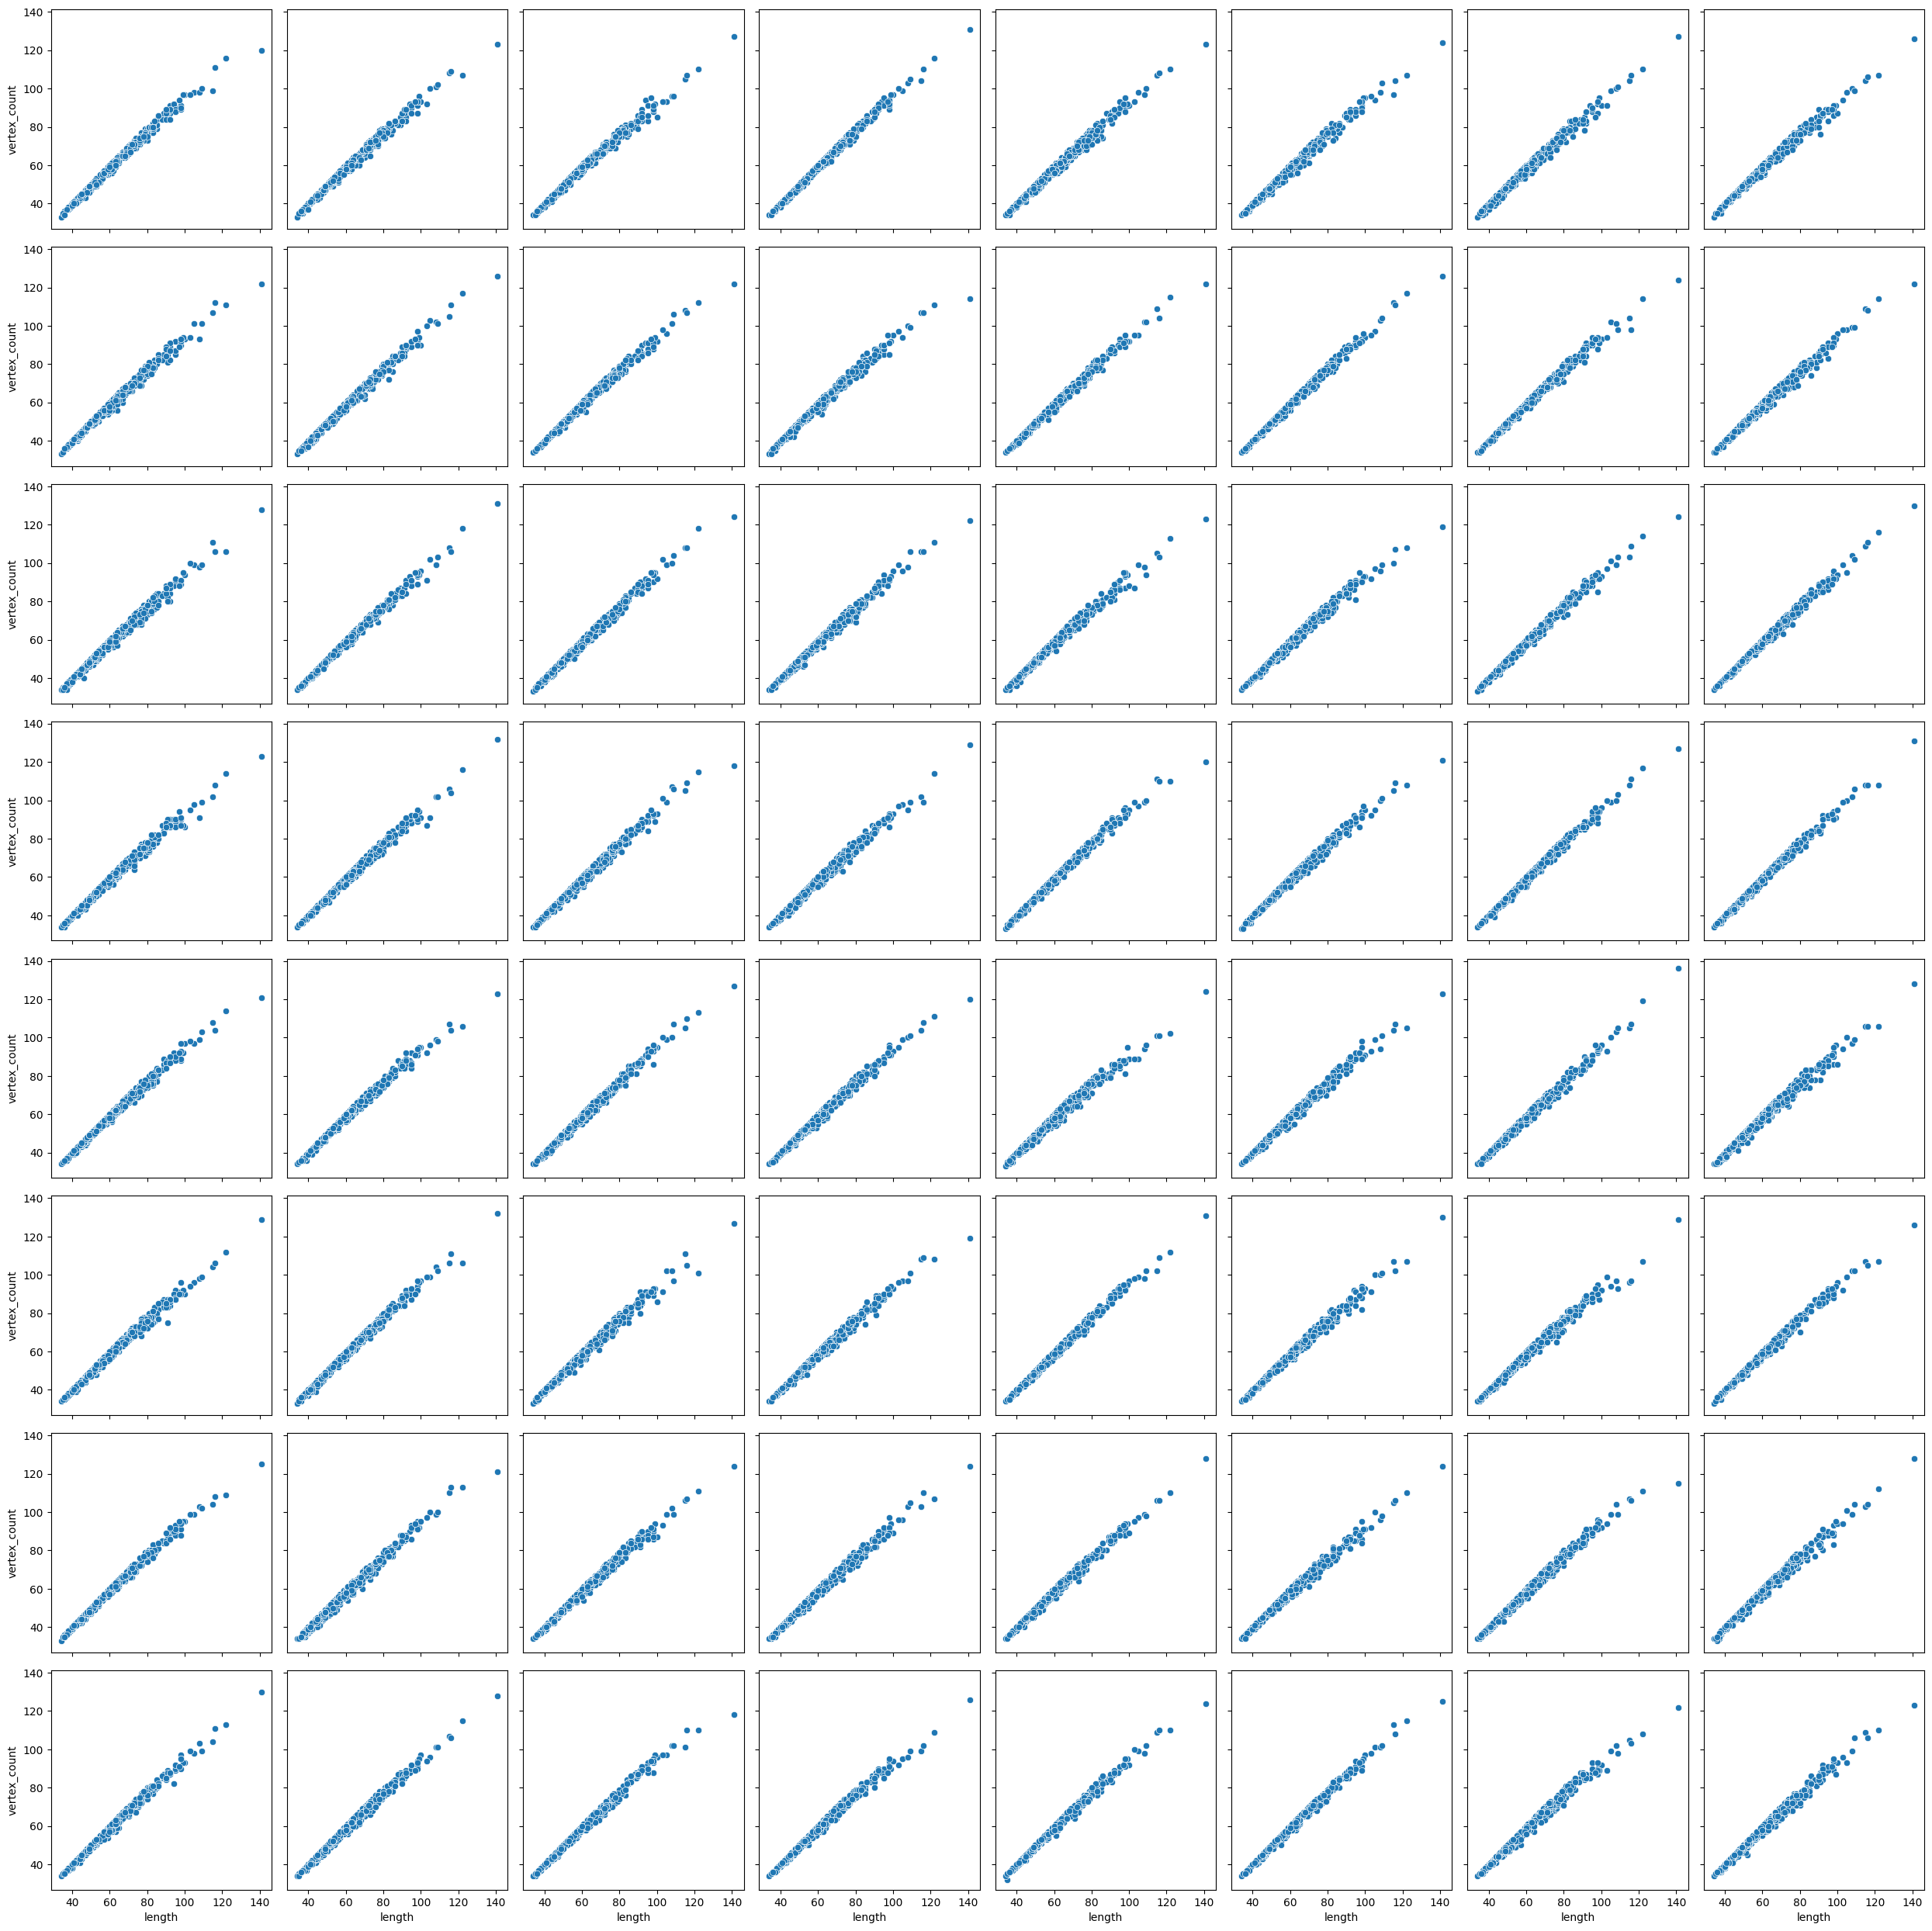

In [14]:
'''
For a each question, what is the relationship between sequence length and the number of key vectors that are vertices of the convex hull?
'''
stats = dd.read_csv('./experiments/embed_dim_512/64_heads/base/finetune/attn_stats.csv')
stats = stats.groupby(['layer', 'head', 'step']).agg({'vertex': 'sum', 'weight': 'count'}).reset_index().compute()
stats.columns = ['layer', 'head', 'step', 'vertex_count', 'length']

def filter(df, layer, head):
    ret = df[df['layer']==layer]
    ret = ret[ret['head']==head]
    return ret

fig, ax = plt.subplots(HEADS // PLOTS_PER_ROW, PLOTS_PER_ROW, figsize=FIGSIZE, sharex=True, sharey=True)

LAYER = 9
for l in range(LAYER, LAYER + 1):
    for h in range(HEADS):
        r, c = divmod(h, PLOTS_PER_ROW)
        subset = filter(stats, l, h)
        sns.scatterplot(subset, x='length', y='vertex_count', ax=ax[r, c])
plt.tight_layout()
plt.show()

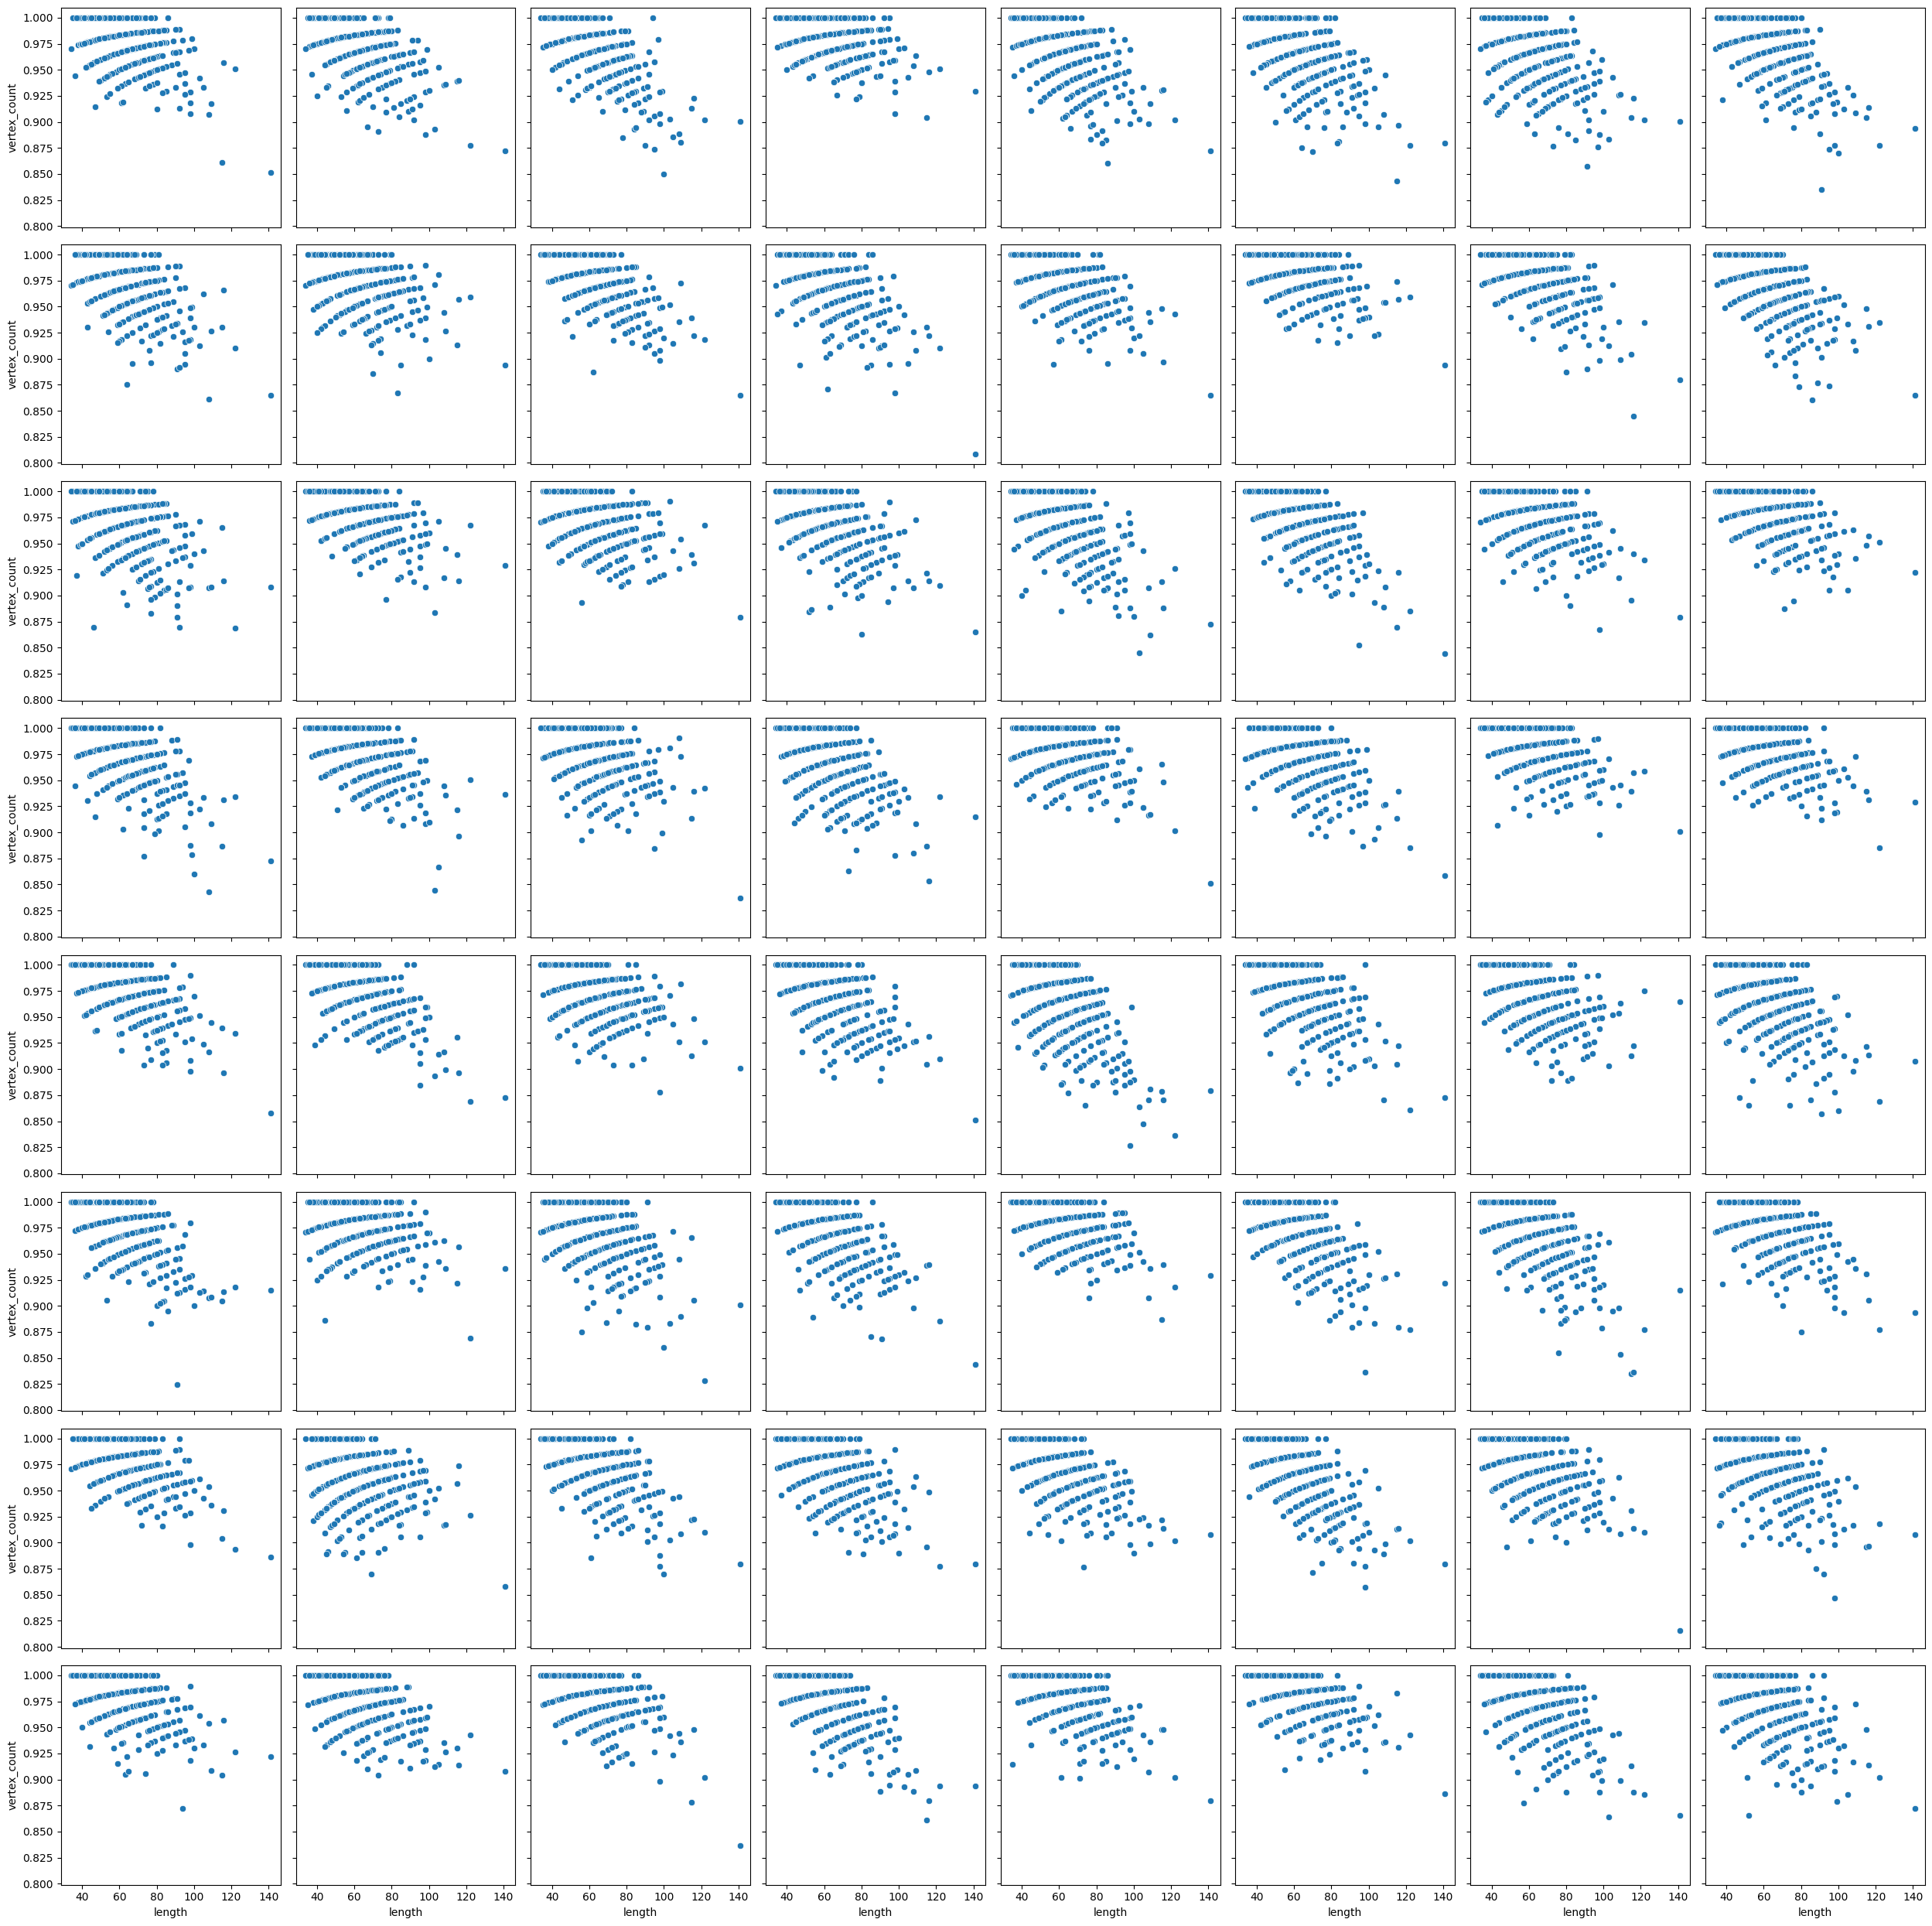

In [15]:
'''
For a each question, what is the relationship between sequence length and the proportion of key vectors that are vertices of the convex hull?
'''
stats = dd.read_csv('./experiments/embed_dim_512/64_heads/base/finetune/attn_stats.csv')
stats = stats.groupby(['layer', 'head', 'step']).agg({'vertex': 'mean', 'weight': 'count'}).reset_index().compute()
stats.columns = ['layer', 'head', 'step', 'vertex_count', 'length']

def filter(df, layer, head):
    ret = df[df['layer']==layer]
    ret = ret[ret['head']==head]
    return ret

fig, ax = plt.subplots(HEADS // PLOTS_PER_ROW, PLOTS_PER_ROW, figsize=FIGSIZE, sharex=True, sharey=True)

LAYER = 9
for l in range(LAYER, LAYER + 1):
    for h in range(HEADS):
        r, c = divmod(h, PLOTS_PER_ROW)
        subset = filter(stats, l, h)
        sns.scatterplot(subset, x='length', y='vertex_count', ax=ax[r, c])
plt.tight_layout()
plt.show()

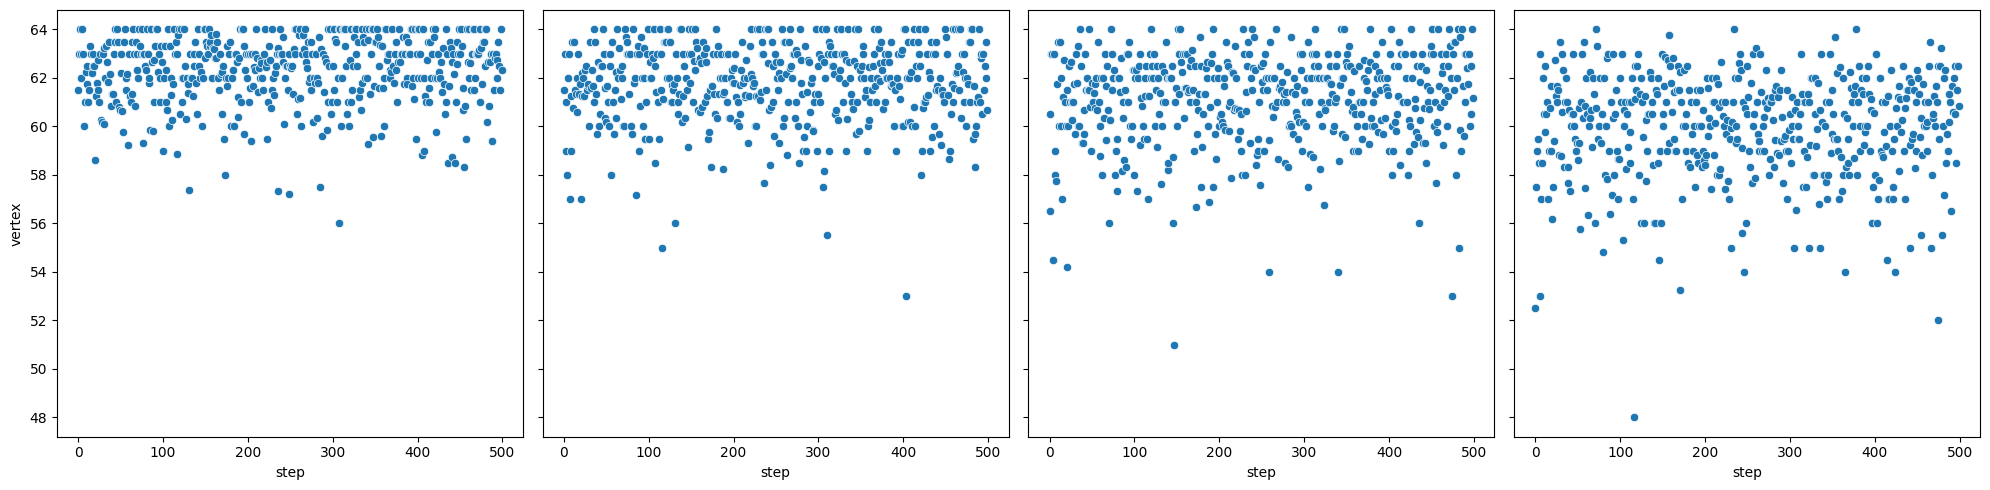

In [79]:
'''
For a given question, are its tokens commonly a vertex of the convex hulls of heads within the same layer?
'''
stats = dd.read_csv('./experiments/embed_dim_512/64_heads/base/finetune/attn_stats.csv')
stats = stats.groupby(['step', 'pos', 'layer']).agg({'vertex': 'sum', 'token': 'mean'}).reset_index() # groupby 'pos' because a token can appear multiple times in a question
stats = stats.groupby(['step', 'token', 'layer']).agg({'vertex': 'mean'}).reset_index().compute()     # if a token occurs multiple times per question, average their vertex proportions 

def filter(df, layer, token):
    ret = df[df['token']==token]
    ret = ret[ret['layer']==layer]
    return ret

fig, ax = plt.subplots(1, LAYERS, figsize=(20,5), sharex=True, sharey=True)

TOKEN = 5
for l in range(LAYERS):
    subset = filter(stats, l+8, TOKEN)
    sns.scatterplot(subset, x='step', y='vertex', ax=ax[l])
plt.tight_layout()
plt.show()

# 8-head Plots

In [2]:
'''
Hyperparameters for Visualizations
'''
HEADS = 8
LAYERS = 12
PLOTS_PER_ROW = 8
assert HEADS % PLOTS_PER_ROW == 0
FIGSIZE = (25, 25)

stats = dd.read_csv('./experiments/embed_dim_512/8_heads/base/finetune/attn_stats_2.csv')

In [6]:
'''
How do heads spread attention throughout the sequence length? What is the average attention weight assigned to each position?
'''
stats = stats.groupby(['layer', 'head', 'pos']).agg({'weight': 'mean'}).reset_index().compute()

def filter(df, layer, head):
    ret = df[df['layer']==layer]
    ret = ret[ret['head']==head]
    return ret

fig, ax = plt.subplots(HEADS*LAYERS // PLOTS_PER_ROW, PLOTS_PER_ROW, figsize=FIGSIZE, sharex=True, sharey=True)

for l in range(LAYERS):
    for h in range(HEADS):
        subset = filter(stats, l, h)
        sns.scatterplot(subset, x='pos', y='weight', ax=ax[l, h])
plt.tight_layout()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'compute'

In [ ]:
'''
How do heads spread attention throughout the sequence length? What is the average attention weight assigned to each position?
'''
stats = stats.groupby(['layer', 'head', 'pos']).agg({'weight': 'mean'}).reset_index().compute()

def filter(df, layer, head):
    ret = df[df['layer']==layer]
    ret = ret[ret['head']==head]
    return ret

fig, ax = plt.subplots(HEADS*LAYERS // PLOTS_PER_ROW, PLOTS_PER_ROW, figsize=FIGSIZE, sharex=True, sharey=True)

for l in range(LAYERS):
    for h in range(HEADS):
        subset = filter(stats, l, h)
        sns.scatterplot(subset, x='pos', y='weight', ax=ax[l, h])
plt.tight_layout()
plt.show()